<td>
<a href="https://colab.research.google.com/github/raoulg/MADS-DAV/blob/main/notebooks/06.2-modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</td>

In [1]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from loguru import logger

This notebook is an implementation of the approach described in this [essay](https://www.orphanalytics.com/en/news/whitepaper202012/OrphAnalyticsQAnon2020.pdf) and written about [here](https://www.prnewswire.com/news-releases/qanon-is-two-different-people-shows-machine-learning-analysis-from-orphanalytics-301192981.html).

It analyzes the posts of QAnon, and concludes that the messages are probably written by two persons instead of one.

From the last link:
>  QAnon has spread conspiracy theories to an unprecedentedly large audience. Its thousands of online messages have popularized narratives such as the existence of a child-trafficking deep state. Recently, it inspired a series of violent attacks and was listed as a terrorist threat by the FBI. The Swiss company OrphAnalytics just published an analysis of all messages posted by Q. Its patented technology aims at identifying authors of written documents. It has found two individual signals within the corpus of Q messages. Its new study contributes to revealing the origins and the persons behind one of the most impactful conspiracy theories in recent times.

We will replicate their analysis with "patented technoloy" with a simple sklearn approach.

In [2]:
datadir = Path.home() / ".cache/mads_datasets/qanon"
if not datadir.exists():
    datadir.mkdir(parents=True)

datafile = datadir / "posts.json"
if not datafile.exists():
    logger.info("Downloading QAnon data")
    url = "https://raw.githubusercontent.com/jkingsman/JSON-QAnon/main/posts.json"
    response = requests.get(url, timeout=10)
    with datafile.open("wb") as f:
        f.write(response.content)
else:
    logger.info(f"QAnon data already downloaded at {datafile}")

2025-10-14 17:27:23.784 | INFO     | __main__:<module>:13 - QAnon data already downloaded at /Users/luiginocleofa/.cache/mads_datasets/qanon/posts.json


On Linux and macOS, the default encoding is typically UTF-8.
On Windows, the default encoding is not UTF-8 but rather a locale-specific encoding, often CP1252 or similar. Because, why not use your own proprietary encoding, just to be backwards compatible, even though the rest of the world uses something different?

If you are running this code on a windows machine, you will need to specify the encoding as 'utf-8', like I did below:

In [3]:
from pandas import json_normalize
import json

with datafile.open(encoding="utf-8") as f:
    df = json_normalize(json.load(f)["posts"], sep="_")

In [4]:
df.dtypes

text                          object
referenced_posts              object
post_metadata_author          object
post_metadata_source_board    object
post_metadata_source_site     object
post_metadata_time             int64
post_metadata_id               int64
post_metadata_author_id       object
images                        object
post_metadata_tripcode        object
post_metadata_source_link     object
dtype: object

## Clean up the timestamps

The text describes they used the analysis from [this](https://www.businessinsider.com/every-qanon-message-q-drop-analyzed-2020-10?international=true&r=US&IR=T) businessinsider article to bin the timeseries.

<img src="../img/Qanon.png" width=450 height=400 />

These dates are hardcoded in the bin_time method.

In [5]:
df["time"] = df["post_metadata_time"].apply(pd.to_datetime, unit="s")

📊 Why do this?

This makes it easy to group or compare posts by different time periods — for example, to see if writing style or authorship changes over time.

In [6]:
from datetime import datetime


def bin_time(time):
    if time < datetime(2017, 12, 1):
        return 0
    elif time < datetime(2018, 1, 6):
        return 1
    elif time < datetime(2018, 8, 10):
        return 2
    elif time < datetime(2019, 8, 1):
        return 3
    else:
        return 4


df["bintime"] = df["time"].apply(lambda x: bin_time(x))

In [7]:
from datetime import timezone
datetime(2017, 12, 1, tzinfo=timezone.utc)

datetime.datetime(2017, 12, 1, 0, 0, tzinfo=datetime.timezone.utc)

In [8]:
df["bintime"].value_counts()

bintime
3    1743
4    1398
2    1359
0     239
1     227
Name: count, dtype: int64

Let's clean up the text some more. We will replace linebreaks ("\n") with spaces, remove urls and set everything to lowercase.

In [9]:
import re


def remove_url(text):
    return re.sub(r"^https?:\/\/.*[\r\n]*", "", text)


df["text"] = df["text"].apply(lambda x: str(x).replace("\n", " "))
df["text"] = df["text"].apply(lambda x: remove_url(x))
df["text"] = df["text"].apply(lambda x: x.lower())

Now, we count every text and filter chuncks with size below 50.

In [10]:
df["size"] = df["text"].apply(lambda x: len(str(x)))
df = df[df["size"] > 50]
df.reset_index(inplace=True, drop=True)

The paper describes batching all the text into chunks of 7500 characters. We can obtain sort of the same by splitting the text up into 100 batches, 7.7k each.

In [11]:
def batch_seq(text, k):
    longseq = " ".join(text)
    n = int(len(longseq) / k)
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
    return parts, n


z = 100
parts, n = batch_seq(df["text"], k=z)
parts = parts[:-1]
len(parts), n

(100, 7734)

In [12]:
# This gives us groups of 100 posts
df["size"].cumsum() // n

0        0
1        0
2        0
3        0
4        0
        ..
2261    99
2262    99
2263    99
2264    99
2265    99
Name: size, Length: 2266, dtype: int64

In [13]:
# Lets store that group in the dataframe
df.loc[:, "group"] = df["size"].cumsum() // n

The paper uses a ngram with size 3 on characterlevel. We can do that with `CountVectorizer`

How does this work? We will get a matrix with 100 rows (one for every group) and many columns. What are these columns? This are the trigram-counts. Let's see how this works: for example, if I have the string "yellow banana", we get the trigrams: " y", "ye", "el", "ll", "lo", "ow", "w ", " b", "ba", "an", "na", "an", "na". We can see that the trigram "an" appears twice. So, the column "an" will have the value 2, the other trigrams have the value 1. 

👉 Creates a CountVectorizer that:

Looks at characters, not words (analyzer="char").

Uses 3-character sequences (ngram_range=(3, 3)), called trigrams.

Example:
Text: "hello" → trigrams: "hel", "ell", "llo"

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

example = ["yellow banana", "papagena papaya banana"]
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
trigram_example = vectorizer.fit_transform(example)
logger.info(f"The trigrams are: {vectorizer.get_feature_names_out()}")
logger.info(f"Shape of the trigram matrix: {trigram_example.shape}")
trigram_example.toarray()

2025-10-14 17:27:25.430 | INFO     | __main__:<module>:6 - The trigrams are: [' ba' ' pa' 'a b' 'a p' 'age' 'ana' 'apa' 'aya' 'ban' 'ell' 'ena' 'gen'
 'llo' 'low' 'na ' 'nan' 'ow ' 'pag' 'pap' 'pay' 'w b' 'ya ' 'yel']
2025-10-14 17:27:25.432 | INFO     | __main__:<module>:7 - Shape of the trigram matrix: (2, 23)


array([[1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1],
       [1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1,
        0]])

In this example, we see the model counted 23 different trigrams.

Now let's proceed to do the same with our text.

In [15]:
import numpy as np

vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
X.shape

(100, 23075)

You can see we found 23074 different trigrams in our text.

We can now calculates the pairwise manhattan distances. That way, we get an idea how how different every chunk is, when compared to all other chunks, in terms of the ngrams. If the vectors are similar, the distance is zero, if they are very different, the distance is high.

This will give us a 100x100 matrix with the distances, for every vector the distance to all other vectors.

👉 This compares every text chunk (from X) with every other chunk.

X is the matrix of trigram counts (numbers representing each chunk).

manhattan_distances(X, X) calculates how far apart each pair of chunks is.

This code builds a big table showing how different each text chunk is from every other chunk based on the patterns of letters they use.

We want to see which chunks of text are similar and which are different in writing style.
Maybe one group of chunks was written by one person, and another group by someone else.

🧩 Why compare every chunk to every other one?

Because we don’t know in advance which chunks belong together — so we need to check all possible pairs.

Example:
If you have 4 chunks (A, B, C, D),
you can compare them like this:

| Compare | Meaning                 |
|----------|-------------------------|
| A vs B  | how similar A and B are |
| A vs C  | how similar A and C are |
| A vs D  | ...                     |
| B vs C  | ...                     |
| B vs D  | ...                     |
| C vs D  | ...                     |


What the distance (vector) tells you

A small distance = two chunks are very similar (probably same writing style).

A large distance = they are different (maybe different author or topic).

📊 The result:

When you plot or cluster these distances, you can see groups of chunks that are close together — meaning they likely come from the same author or writing pattern.

💡 In short:

We compare every chunk with every other chunk so we can measure how all parts of the text relate to each other — that’s how we find patterns, clusters, or possible different authors.

In [16]:
from sklearn.metrics.pairwise import manhattan_distances

# This compares every text chunk (from X) with every other chunk.
distance = manhattan_distances(X, X)
distance.shape, type(distance)

((100, 100), numpy.ndarray)

To handle the labels, we make integers of the labels.

🧠 What this code does

It takes the text source names (like website names) from the data and turns them into numbers — because machine learning models work better with numbers than with text labels.

In [17]:
labels = df["post_metadata_source_site"].unique()
mapping = {labels[i]: i for i in range(3)}
df["source"] = df["post_metadata_source_site"].apply(lambda x: mapping[x])
source_names = {v: k for k, v in mapping.items()}
source_names

{0: '4ch', 1: '8ch', 2: '8kun'}

run PCA on the distance matrix (100×100) producing two principal components for each chunk.

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
model = pca.fit_transform(distance)

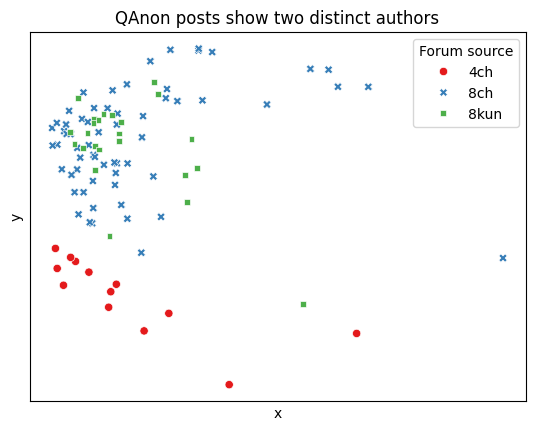

In [19]:
import matplotlib.pyplot as plt

sourcemean = np.round(df.groupby("group").source.mean()).values.reshape(-1, 1)
timemean = np.round(df.groupby("group").bintime.mean()).values.reshape(-1, 1)
p = pd.DataFrame(
    np.concatenate([model, sourcemean, timemean], axis=1),
    columns=["x", "y", "source", "time"],
).reset_index()
p["source"] = p["source"].map(source_names)
sns.scatterplot(data=p, x="x", y="y", hue="source", style="source", palette="Set1")
plt.yticks([])
plt.xticks([])
plt.title("QAnon posts show two distinct authors")
plt.legend(title="Forum source")

This reproduces the main conclusion, that the red source is not overlapping with the other two sources.

Of course, this tells you nothing about how high the chance is, that this is actually caused by having two authors, or by somehow changing the writing style.

For that, we would need access to how likely it is that the writing style changes this much.

However, we still have reproduced their "patented technology" with a few lines of code.
Let's wrap it into a class:

The scatter plot shows points representing chunks of QAnon posts, colored by which forum they were posted on:

🔴 4chan (red circles)

🔵 8chan (blue crosses)

🟩 8kun (green squares)

Each point’s position comes from analyzing writing patterns (character trigrams).
The closer two points are, the more similar the writing style.

📊 What the plot shows:

The red points (4chan) are grouped separately from the blue and green points (8chan & 8kun).

This means the writing style of 4chan posts is clearly different from the style of later posts on 8chan/8kun.

The 8chan and 8kun posts are mixed together, showing they are similar in style.


🧩 Conclusion:

The QAnon posts appear to have been written by two different people or writing styles —
one responsible for the early 4chan posts, and another for the later 8chan/8kun posts.

This matches the finding from the original analysis:
👉 There were likely two distinct authors behind the QAnon messages.

In [20]:
import sys
from pathlib import Path

print(sys.path)  # check the paths where Python is searching
print((Path("..") / "wa_analyzer").exists())  # should be True


['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/.venv/lib/python3.12/site-packages', '/Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/src']
False


2025-10-14 17:27:27.489 | INFO     | wa_analyzer.model:batch_seq:26 - Splitting text into 100 parts of 7734 characters each
2025-10-14 17:27:27.491 | INFO     | wa_analyzer.model:batch_seq:29 - Removing 1 parts
2025-10-14 17:27:28.208 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (100, 23075)
2025-10-14 17:27:28.590 | INFO     | wa_analyzer.model:reduce_dims:42 - Using PCA


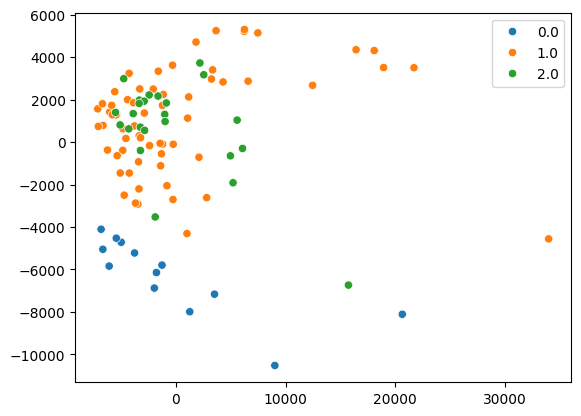

In [21]:
import sys

sys.path.insert(0, "..")

from wa_analyzer.model import TextClustering

clustering = TextClustering()
labels = sourcemean.flatten().astype(str)
clustering(text=df["text"], k=100, labels=labels, batch=True, method="PCA")

And now lets test it on the whatsapp data:

In [22]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
wa_df = pd.read_parquet(datafile)
wa_df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,msg_length
0,2023-02-01 19:59:48+00:00,"Dank voor bericht, Marijke",kooky-tapir,False,False,26,False,evening,19:59:48,2,26
1,2023-02-01 20:46:43+00:00,"Herman goede avond, Mag ik de telefoon nummer...",dynamic-frog,False,False,87,False,evening,20:46:43,2,87
2,2023-02-01 20:52:10+00:00,Voor Ista metertje: 010 2455700,intense-toad,False,True,31,False,evening,20:52:10,2,31
3,2023-02-01 20:52:45+00:00,"Dit gaat dus via Ista, niet via De Combi",intense-toad,False,True,40,False,evening,20:52:45,2,40
4,2023-02-01 20:55:55+00:00,Bedankt Herman 👍🏽🙏🏽,dynamic-frog,True,False,19,False,evening,20:55:55,2,19


We know the authors, so let's use the labels.

In [23]:
authors = list(np.unique(wa_df.author))

We take a subset of every author, and join their texts.
Obviously, you can only do this if you know the authors, or at least the claimed authors. Concatenating all texts together will make the data useless. 

In [ ]:
n = 500
min_parts = 2

corpus = {}
for author in authors:
    subset = wa_df[wa_df.author == author].reset_index()
    longseq = " ".join(subset.message)
    # chunk everything into n-sized parts
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
    # clean urls
    parts = [remove_url(chunk) for chunk in parts]
    # remove double spaces
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    # keep only parts with more than min_parts
    if len(parts) > min_parts:
        corpus[author] = parts
corpus.keys()

dict_keys(['bold-bison', 'bouncy-worm', 'cackling-eland', 'captivating-dove', 'carefree-lark', 'cheerful-boar', 'cheerful-mule', 'chuckling-stork', 'coltish-owl', 'cordial-eel', 'dazzling-curlew', 'dazzling-yak', 'dynamic-frog', 'ebullient-mosquito', 'elaborate-jay', 'entertaining-pig', 'ethereal-lapwing', 'eye-catching-hare', 'eye-catching-okapi', 'flexible-platypus', 'freckled-wolverine', 'funny-swallow', 'goofy-tiger', 'happy-beaver', 'hilarious-dogfish', 'intense-toad', 'joyful-okapi', 'kooky-tapir', 'limber-ostrich', 'loony-albatross', 'lustrous-reindeer', 'mind-blowing-kudu', 'multicolored-dogfish', 'pellucid-quelea', 'peppy-rat', 'piebald-rhinoceros', 'quick-chamois', 'radiant-coyote', 'resplendent-aardwolf', 'rollicking-ostrich', 'saturated-whistling duck', 'silky-lapwing', 'snorting-ibex', 'soft-eland', 'splattered-barracuda', 'springy-hare', 'stippled-pig', 'sudsy-eland', 'sudsy-jellyfish', 'sunny-gazelle', 'upbeat-pigeon', 'vivid-rhinoceros', 'waggish-porcupine', 'wispy-rein

: 

In [ ]:
import matplotlib.pyplot as plt

text = [part for text in corpus.values() for part in text]
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
# we set batch to false, because we already batched the data
clustering(text=text, k=100, labels=wa_labels, batch=False, method="tSNE")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset")

2025-10-14 17:27:29.862 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (880, 13675)
2025-10-14 17:27:42.919 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE
